# Sampling from a diffusion model

<!--- @wandbcode{dlai_03} -->

In this notebook we will sample from the previously trained diffusion model.
- We are going to compare the samples from DDPM and DDIM samplers
- Visualize mixing samples with conditional diffusion models

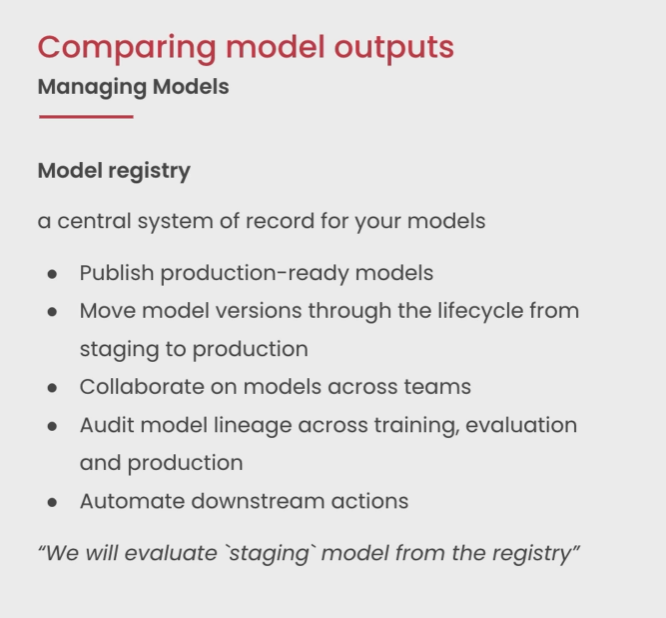
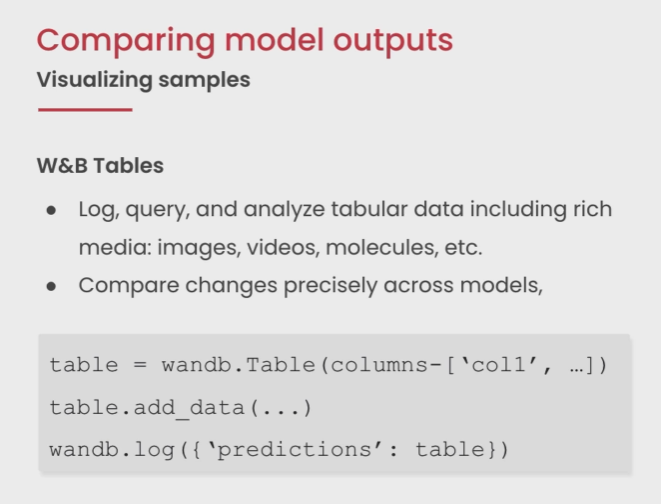

In [ ]:
from pathlib import Path
from types import SimpleNamespace
import torch
import torch.nn.functional as F
import numpy as np
from utilities import *

import wandb

In [ ]:
wandb.login(anonymous="allow")

# Setting Things Up

In [ ]:
# Wandb Params
MODEL_ARTIFACT = "dlai-course/model-registry/SpriteGen:latest"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

config = SimpleNamespace(
    # hyperparameters
    num_samples=30,

    # ddpm sampler hyperparameters
    timesteps=500,
    beta1=1e-4,
    beta2=0.02,

    # ddim sampler hp
    ddim_n=25,

    # network hyperparameters
    height=16,
)

In the previous notebook we saved the best model as a wandb Artifact (our way of storing files during runs). We will now load the model from wandb and set up the sampling loop.

In [ ]:
def load_model(model_artifact_name):
    "Load the model from wandb artifacts"
    api = wandb.Api()
    artifact = api.artifact(model_artifact_name, type="model")
    model_path = Path(artifact.download())

    # recover model info from the registry
    producer_run = artifact.logged_by()

    # load the weights dictionary
    model_weights = torch.load(model_path/"context_model.pth",
                               map_location="cpu")

    # create the model
    model = ContextUnet(in_channels=3,
                        n_feat=producer_run.config["n_feat"],
                        n_cfeat=producer_run.config["n_cfeat"],
                        height=producer_run.config["height"])

    # load the weights into the model
    model.load_state_dict(model_weights)

    # set the model to eval mode
    model.eval()
    return model.to(DEVICE)


In [ ]:
nn_model = load_model(MODEL_ARTIFACT)

## Sampling

We will sample and log the generated samples to wandb.

In [ ]:
_, sample_ddpm_context = setup_ddpm(config.beta1,
                                    config.beta2,
                                    config.timesteps,
                                    DEVICE)

Let's define a set of noises and a context vector to condition on.

In [ ]:
# Noise vector
# x_T ~ N(0, 1), sample initial noise
noises = torch.randn(config.num_samples, 3,
                     config.height, config.height).to(DEVICE)

# A fixed context vector to sample from
ctx_vector = F.one_hot(torch.tensor([0, 0, 0, 0, 0, 0,   # hero
                                     1, 1, 1, 1, 1, 1,   # non-hero
                                     2, 2, 2, 2, 2, 2,   # food
                                     3, 3, 3, 3, 3, 3,   # spell
                                     4, 4, 4, 4, 4, 4]),  # side-facing
                       5).to(DEVICE).float()

Let's bring that faster DDIM sampler from the diffusion course.

In [ ]:
sample_ddim_context = setup_ddim(config.beta1,
                                 config.beta2,
                                 config.timesteps,
                                 DEVICE)


### Sampling:
let's compute ddpm samples as before

In [ ]:
ddpm_samples, _ = sample_ddpm_context(nn_model, noises, ctx_vector)

For DDIM we can control the step size by the `n` param:

In [ ]:
ddim_samples, _ = sample_ddim_context(nn_model,
                                      noises,
                                      ctx_vector,
                                      n=config.ddim_n)

### Visualizing generations on a Table
Let's create a `wandb.Table` to store our generations

In [ ]:
table = wandb.Table(columns=["input_noise", "ddpm", "ddim", "class"])

We can add the rows to the table one by one, we also cast images to `wandb.Image` so we can render them correctly in the UI

In [ ]:
for noise, ddpm_s, ddim_s, c in zip(noises,
                                    ddpm_samples,
                                    ddim_samples,
                                    to_classes(ctx_vector)):

    # add data row by row to the Table
    table.add_data(wandb.Image(noise),
                   wandb.Image(ddpm_s),
                   wandb.Image(ddim_s),
                   c)

we log the table to W&B, we can also use `wandb.init` as a context manager, this way we ensure that the run is finished when exiting the manager.

In [ ]:
with wandb.init(project="dlai_sprite_diffusion", 
                job_type="samplers_battle", 
                config=config):
    
    wandb.log({"samplers_table":table})